In [35]:
import tensorflow as tf
from tensorflow.keras import models, layers

# Configure GPU settings
# Select and configure the GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            # Enable memory growth to avoid full allocation
            tf.config.experimental.set_memory_growth(gpu, True)
            # Set the visible device to the first GPU
            tf.config.set_visible_devices(gpus[0], 'GPU')

        # List logical devices to confirm GPU activation
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs are initialized
        print(e)

# Check if the default device is GPU
print("Default GPU Device: ", tf.test.gpu_device_name())
print("Is GPU available: ", len(tf.config.list_physical_devices('GPU')) > 0)


1 Physical GPUs, 1 Logical GPUs
Default GPU Device:  /device:GPU:0
Is GPU available:  True


In [36]:
# Batch size for training and validation
BATCH_SIZE = 32
# Image size (height and width). Assuming square images.
IMAGE_SIZE = 256
# Number of channels in the images. 3 for RGB color images.
CHANNELS = 3
# Number of epochs for training the model
EPOCHS = 50

In [37]:
# Create a dataset from the images in the specified directory
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "YaprakDataset",             # Path to the directory containing the dataset
    seed=123,                    # Random seed for shuffling and transformations
    shuffle=True,                # Shuffle the dataset to ensure randomization
    image_size=(IMAGE_SIZE, IMAGE_SIZE),  # Resize images to the specified size
    batch_size=BATCH_SIZE,       # Number of images to return in each batch
)


Found 7137 files belonging to 6 classes.


In [38]:
# Get the class names from the dataset
class_names = dataset.class_names
# Print the list of class names
class_names


['Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus']

In [39]:
# Iterate over the dataset to get a single batch of images and labels
for image_batch, labels_batch in dataset.take(1):
    # Print the shape of the image batch
    print(image_batch.shape)  # Shape will be (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
    
    # Print the labels for the batch as a numpy array
    print(labels_batch.numpy())  # Labels will be a numpy array of size BATCH_SIZE

(32, 256, 256, 3)
[1 1 4 4 4 1 4 3 4 5 3 1 4 4 3 4 4 4 4 4 1 3 3 4 1 4 0 0 4 4 4 4]


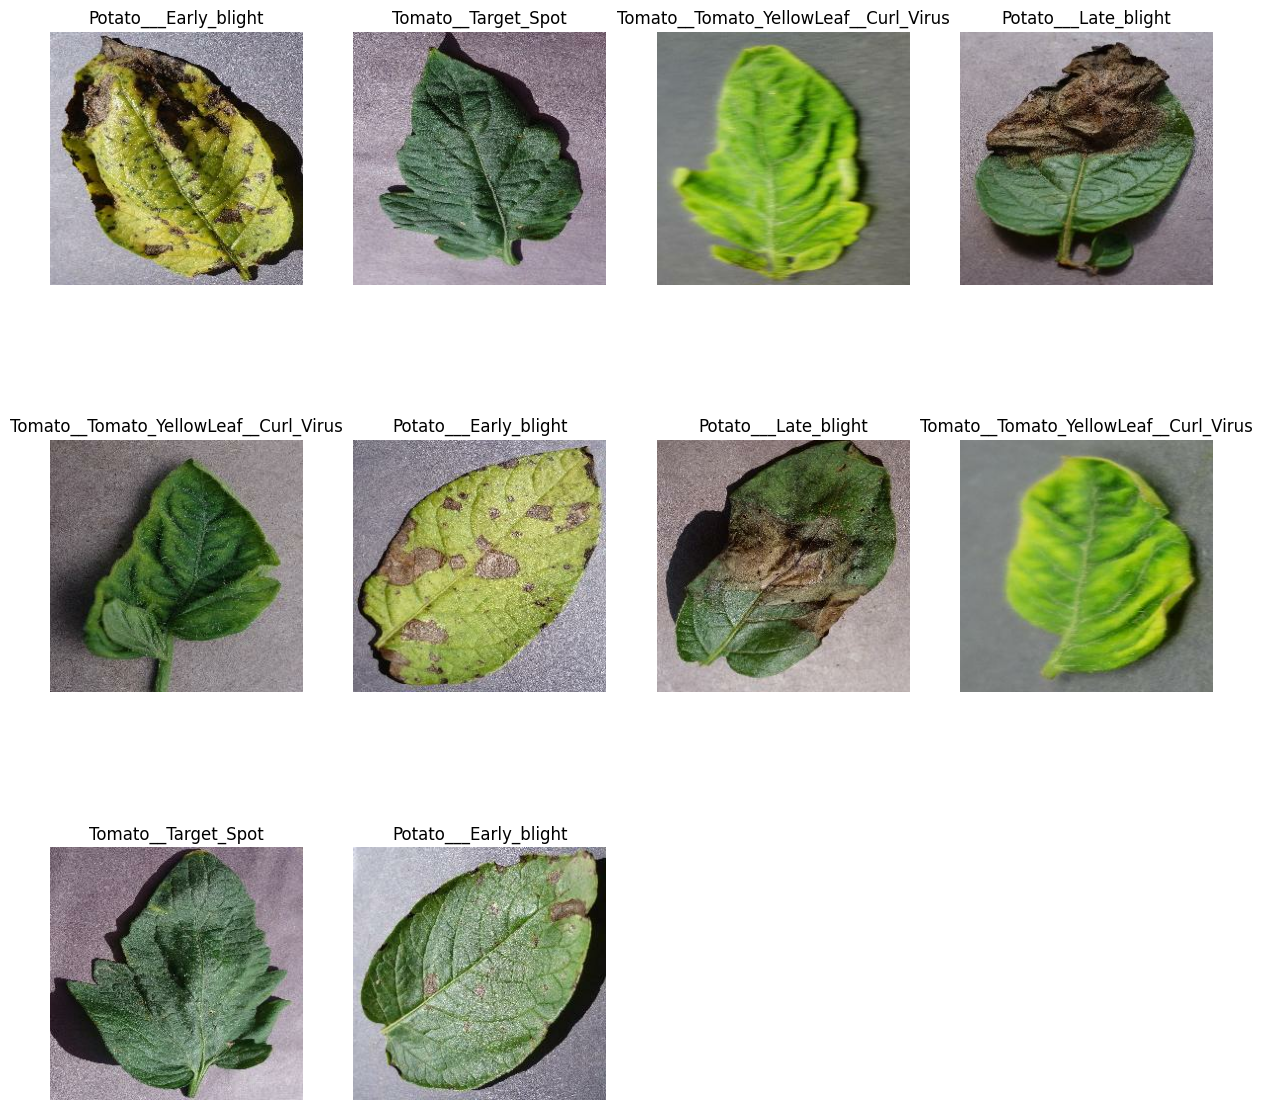

In [40]:
import matplotlib.pyplot as plt

# Create a figure 
plt.figure(figsize=(15, 15))

# Iterate over the dataset to get a single batch of images and labels
for image_batch, labels_batch in dataset.take(1):
    # Iterate over the first 10 images in the batch
    for i in range(10):
        # Create a subplot in a 3x4
        ax = plt.subplot(3, 4, i + 1)
        
        # Display the image
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        
        # Set the title of class name for image
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [41]:
len(dataset)#Since we set the batch_size to 32, the dataset length became 179.

224

In [42]:
# We set the ratio of the training set to %80
train_size = 0.8
len(dataset)*train_size

179.20000000000002

In [43]:
train_ds = dataset.take(179)  # Takes the first 179 examples
# Calculate the length of the training dataset
len(train_ds)

179

In [44]:
# Create a test dataset by skipping the first 179 examples
test_ds = dataset.skip(179)
# Calculate the length of the test dataset
len(test_ds)

45

In [45]:
# Calculate the size of the validation set by multiplying the length of the dataset with the validation size
val_size = 0.1
len(dataset)*val_size

22.400000000000002

In [46]:
# Create a validation dataset by taking the first 22 examples from the test dataset
val_ds = test_ds.take(22)

# Calculate the length of the validation dataset
len(val_ds)

22

In [47]:
test_ds = test_ds.skip(22)
len(test_ds)

23

In [48]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    """
    Splits a given dataset into training, validation, and test sets according to the specified ratios.
    
    Args:
    - ds: TensorFlow dataset object containing the dataset to be partitioned.
    - train_split: Proportion of the dataset to be allocated for training (default is 0.8).
    - val_split: Proportion of the dataset to be allocated for validation (default is 0.1).
    - test_split: Proportion of the dataset to be allocated for testing (default is 0.1).
    - shuffle: Whether to shuffle the dataset before partitioning (default is True).
    - shuffle_size: Size of the shuffle buffer if shuffling is enabled (default is 10000).
    
    Returns:
    - Tuple containing the training, validation, and test datasets.
    """
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [49]:
# Partition the dataset into training, validation, and test sets using the specified function
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [50]:
len(train_ds)

179

In [51]:
len(val_ds)

22

In [52]:
len(test_ds)

23

In [53]:
# Cache, shuffle, and prefetch the training dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache, shuffle, and prefetch the validation dataset
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Cache, shuffle, and prefetch the test dataset
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [54]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [55]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [56]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [57]:
n_classes = 6
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)

model = models.Sequential([
    # First convolutional layer: 32 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS)),
    # First max pooling layer: 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    
    # Second convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    # Second max pooling layer: 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    
    # Third convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    # Third max pooling layer: 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    
    # Fourth convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    # Fourth max pooling layer: 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    
    # Fifth convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    # Fifth max pooling layer: 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    
    # Sixth convolutional layer: 64 filters, 3x3 kernel, ReLU activation
    layers.Conv2D(64, kernel_size=(3,3), activation='relu'),
    # Sixth max pooling layer: 2x2 pool size
    layers.MaxPooling2D((2, 2)),
    
    # Flatten the 3D output to 1D tensor
    layers.Flatten(),
    
    # Fully connected (dense) layer with 64 units and ReLU activation
    layers.Dense(64, activation='relu'),
    
    # Output layer with 'n_classes' units and softmax activation for classification
    layers.Dense(n_classes, activation='softmax'),
])


model.build(input_shape=input_shape)

In [58]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 64)      

In [59]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [60]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
179/179 [==============================] - 81s 367ms/step - loss: 1.0334 - accuracy: 0.6839 - val_loss: 0.4608 - val_accuracy: 0.8480
Epoch 2/50
179/179 [==============================] - 54s 303ms/step - loss: 0.3684 - accuracy: 0.8710 - val_loss: 0.5155 - val_accuracy: 0.8026
Epoch 3/50
179/179 [==============================] - 52s 292ms/step - loss: 0.3389 - accuracy: 0.8791 - val_loss: 0.3284 - val_accuracy: 0.8935
Epoch 4/50
179/179 [==============================] - 53s 298ms/step - loss: 0.2123 - accuracy: 0.9282 - val_loss: 0.4437 - val_accuracy: 0.8636
Epoch 5/50
179/179 [==============================] - 55s 306ms/step - loss: 0.1991 - accuracy: 0.9340 - val_loss: 0.2946 - val_accuracy: 0.9190
Epoch 6/50
179/179 [==============================] - 52s 290ms/step - loss: 0.1871 - accuracy: 0.9387 - val_loss: 0.3284 - val_accuracy: 0.8991
Epoch 7/50
179/179 [==============================] - 52s 291ms/step - loss: 0.1753 - accuracy: 0.9444 - val_loss: 0.2345 - val_ac

In [61]:
pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.comNote: you may need to restart the kernel to use updated packages.

   ---------------------------------------- 0.0/11.0 MB ? eta -:--:--
   ---------------------------------------- 0.0/11.0 MB 640.0 kB/s eta 0:00:18
   ---------------------------------------- 0.0/11.0 MB 487.6 kB/s eta 0:00:23
   ---------------------------------------- 0.1/11.0 MB 930.9 kB/s eta 0:00:12
    --------------------------------------- 0.3/11.0 MB 1.4 MB/s eta 0:00:08
   - -------------------------------------- 0.5/11.0 MB 2.1 MB/s eta 0:00:05
   -- ------------------------------------- 0.7/11.0 MB 2.5 MB/s eta 0:00:05
   --- ------------------------------------ 1.0/11.0 MB 3.0 MB/s eta 0:00:04
   ----- ---------------------------------- 1.6/11.0 MB 4.5 MB/s eta 0:00:03
   ---------- ----------------------------- 2.9/11.0 MB 7.1 MB/s eta 0:00:02
   --------------- ------------------------ 4.1/11.0 MB 9.1 MB/s eta 0:00:01
   ------------

23/23 [==============================] - 1s 41ms/step


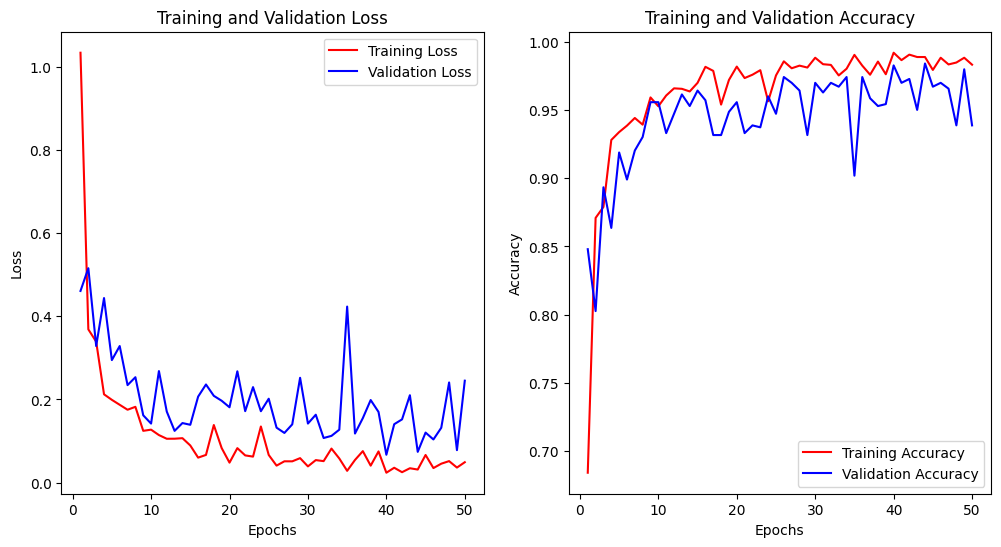

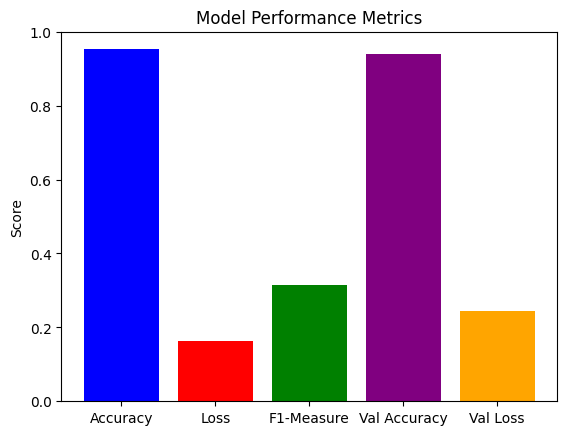

In [62]:
import numpy as np
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt

# Evaluate model performance on test data
test_loss, test_accuracy = model.evaluate(test_ds)

# Make predictions on test data
y_pred = model.predict(test_ds)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get predicted class labels
y_true = np.concatenate([y for x, y in test_ds], axis=0)  # Get true labels

# Calculate F1 score
f1 = f1_score(y_true, y_pred_classes, average='weighted')

# Extract training and validation metrics from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Visualize training and validation metrics
epochs = range(1, len(train_loss) + 1)
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, 'r', label='Training Accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Visualize evaluation metrics with bar chart
metrics = {
    'Accuracy': test_accuracy,
    'Loss': test_loss,
    'F1-Measure': f1,
    'Val Accuracy': val_acc[-1],  # Get last value of validation accuracy
    'Val Loss': val_loss[-1]  # Get last value of validation loss
}
labels = list(metrics.keys())
values = list(metrics.values())
fig, ax = plt.subplots()
ax.bar(labels, values, color=['blue', 'red', 'green', 'purple', 'orange'])
ax.set_ylim(0, 1)  # Set y-axis limits for better visualization
ax.set_title('Model Performance Metrics')
ax.set_ylabel('Score')
plt.show()



First image to predict:
Actual label: Potato___Early_blight
1/1 [==============================] - 0s 51ms/step
Predicted label: Potato___Early_blight


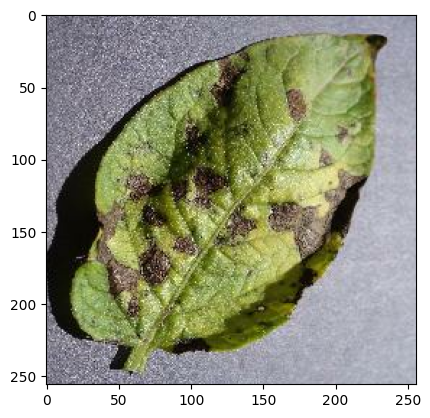

In [73]:
import numpy as np

# Loop through the first batch of images and labels from the test dataset
for images_batch, labels_batch in test_ds.take(1):

    # Extract the first image and label from the batch
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    # Print information about the first image
    print("First image to predict:")
    plt.imshow(first_image)
    print("Actual label:", class_names[first_label])

    # Make a prediction on the first image
    batch_prediction = model.predict(images_batch)
    predicted_label_index = np.argmax(batch_prediction[0])  # Get index of predicted class

    # Print the predicted label
    print("Predicted label:", class_names[predicted_label_index])


In [64]:
def predict(model, img):
  """
  Predicts the class of a given image using the provided model.

  Args:
      model: The trained TensorFlow model for image classification.
      img: A NumPy array representing the image to be predicted.

  Returns:
      A tuple containing the predicted class label and the confidence score.
  """

  # Preprocess the image for the model
  img_array = tf.keras.preprocessing.image.img_to_array(img.numpy())
  img_array = tf.expand_dims(img_array, 0)  # Add a batch dimension

  # Make predictions using the model
  predictions = model.predict(img_array)

  # Get the predicted class and confidence
  predicted_class = class_names[np.argmax(predictions[0])]
  confidence = round(100 * (np.max(predictions[0])), 2)  # Round confidence to 2 decimals

  return predicted_class, confidence


1/1 [==============================] - 0s 23ms/step


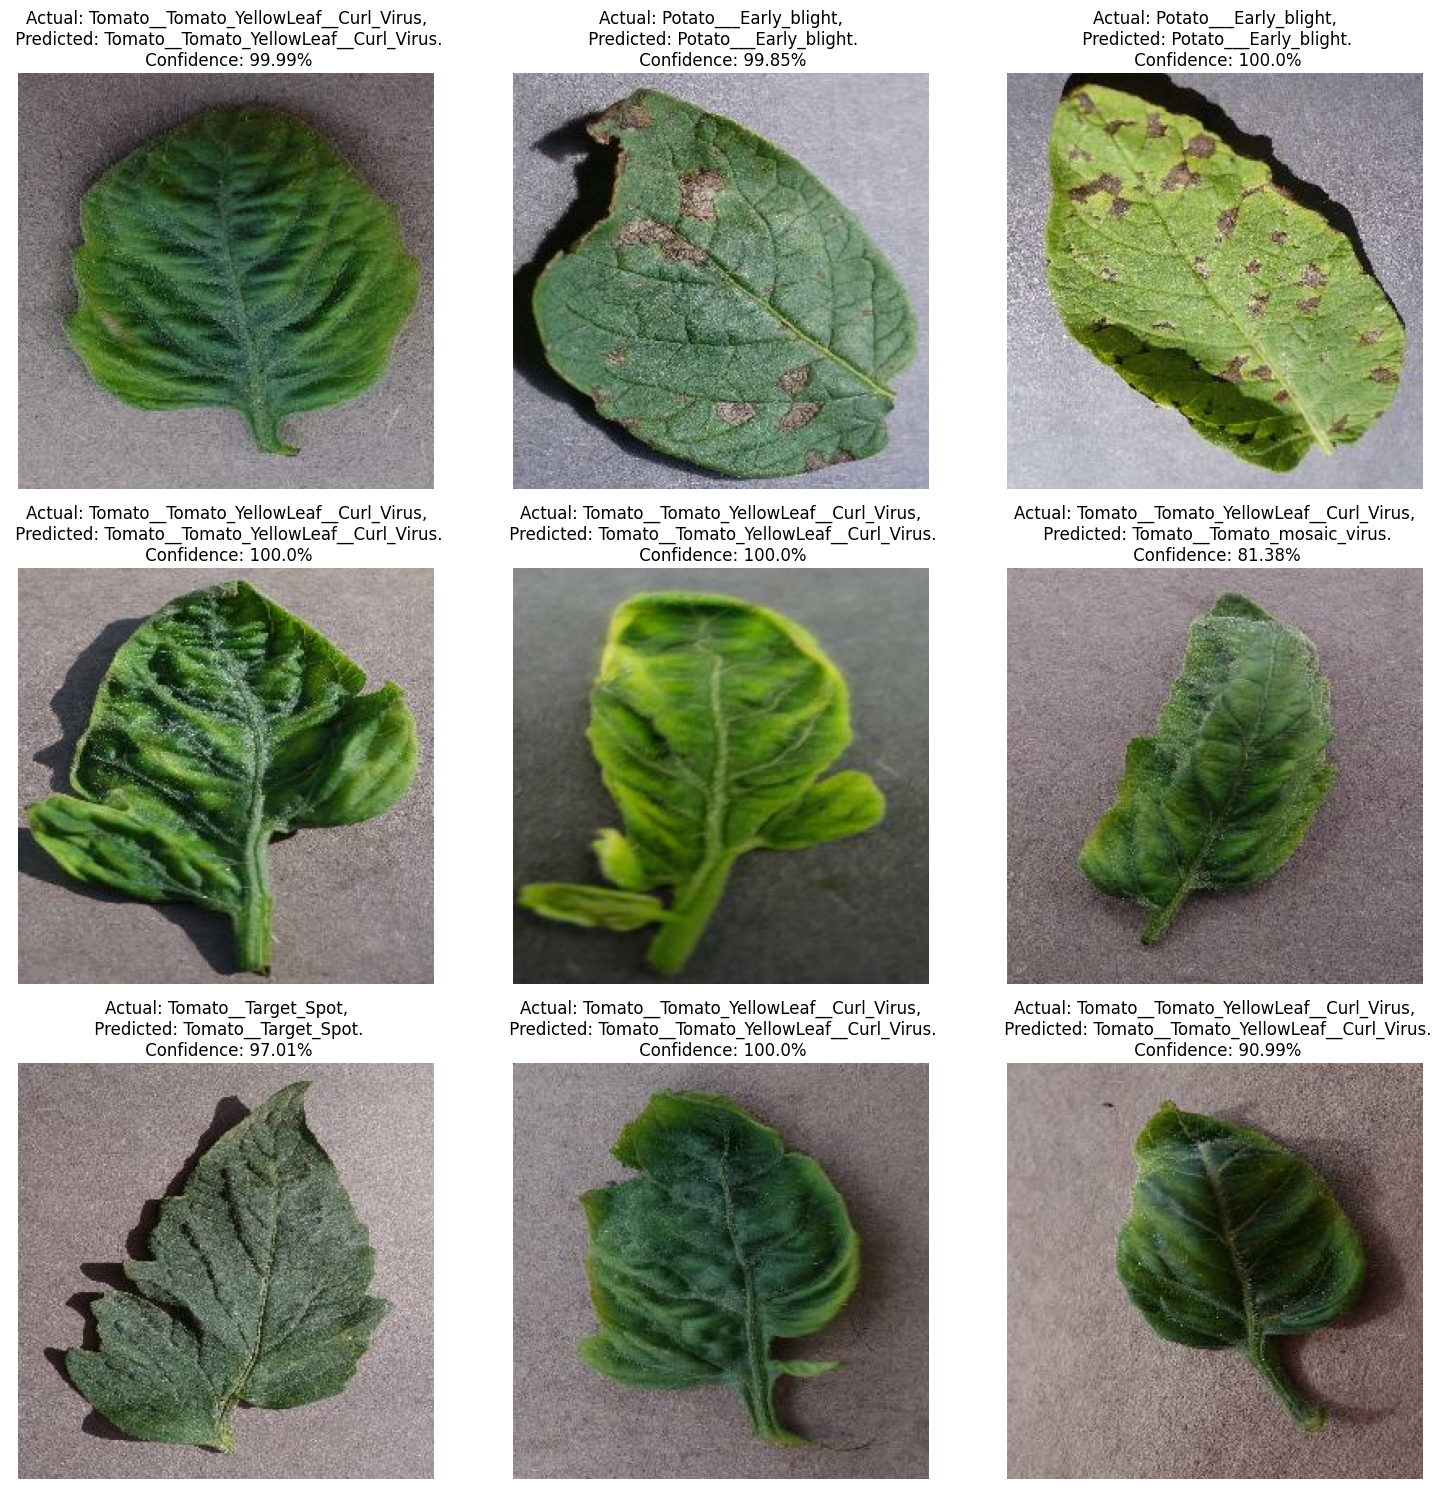

In [75]:
plt.figure(figsize=(15, 15))  # Create a large figure for displaying multiple images

# Loop through the first batch of images and labels from the test dataset
for images, labels in test_ds.take(1):

    # Loop through 9 images (assuming there are 9 images in the batch)
    for i in range(9):

        # Create a subplot for each image
        ax = plt.subplot(3, 3, i + 1)  # 3 rows, 3 columns, starting from subplot 1

        # Display the image
        plt.imshow(images[i].numpy().astype("uint8"))

        # Predict the class and confidence for the image
        predicted_class, confidence = predict(model, images[i].numpy())

        # Get the actual class label from labels
        actual_class = class_names[labels[i]]

        # Create a title combining actual class, predicted class, and confidence
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        # Turn off subplot axes for cleaner presentation
        plt.axis("off")

plt.tight_layout()  # Adjust spacing between subplots for better readability
plt.show()  # Display the plot


In [ ]:
pip install seaborn

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/294.9 kB ? eta -:--:--
   ----- ---------------------------------- 41.0/294.9 kB 2.0 MB/s eta 0:00:01
   ------------------- -------------------- 143.4/294.9 kB 1.7 MB/s eta 0:00:01
   ------------------------------------- -- 276.5/294.9 kB 2.1 MB/s eta 0:00:01
   ---------------------------------------- 294.9/294.9 kB 2.0 MB/s eta 0:00:00
   ---------------------------------------- 0.0/11.6 MB ? eta -:--:--
    --------------------------------------- 0.3/11.6 MB 15.4 MB/s eta 0:00:01
   - -------------------------------------- 0.5/11.6 MB 6.4 MB/s eta 0:00:02
   -- ------------------------------------- 0.7/11.6 MB 5.9 MB/s eta 0:00:02
   ---- ----------------------------------- 1.3/11.6 MB 7.5 MB/s eta 0:00:02
   ------- -------------------------------- 2.3/11.6 MB 10.2 MB/s eta 0:00:01
   ------------- -------------------------- 3.8/11.6 MB 14.3 MB/s eta 0:00:01
  

In [71]:
pip install networkx

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
    --------------------------------------- 0.0/1.7 MB 435.7 kB/s eta 0:00:04
   - -------------------------------------- 0.1/1.7 MB 657.6 kB/s eta 0:00:03
   ---- ----------------------------------- 0.2/1.7 MB 1.1 MB/s eta 0:00:02
   ------- -------------------------------- 0.3/1.7 MB 1.6 MB/s eta 0:00:01
   ------------ --------------------------- 0.5/1.7 MB 2.1 MB/s eta 0:00:01
   ----------------- ---------------------- 0.7/1.7 MB 2.4 MB/s eta 0:00:01
   ------------------------- -------------- 1.1/1.7 MB 3.1 MB/s eta 0:00:01
   ------------------------------------- -- 1.6/1.7 MB 4.1 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 4.2 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


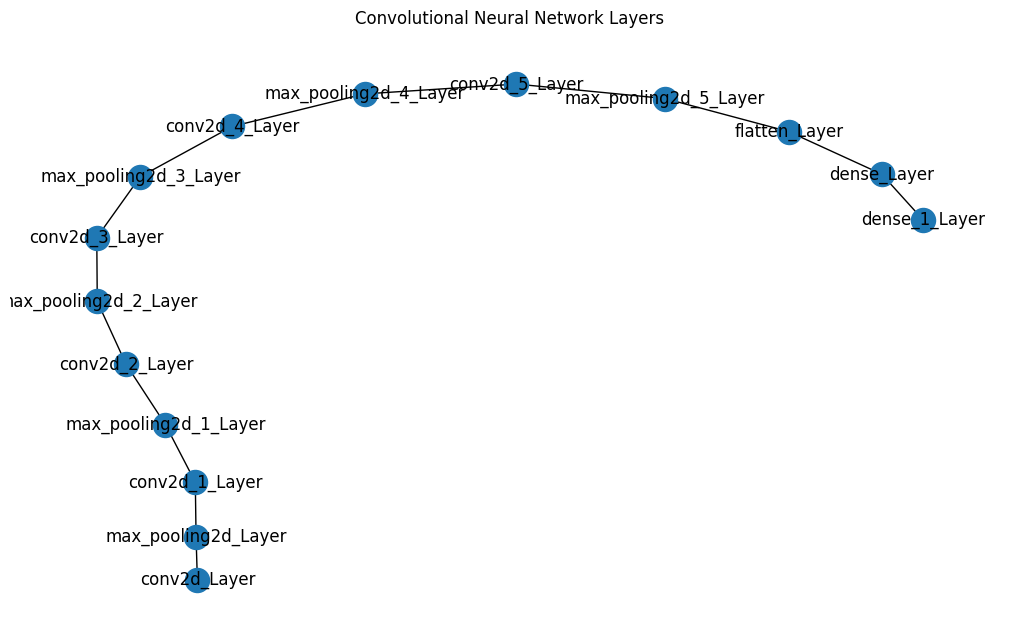

In [76]:
import networkx as nx

# Create an empty NetworkX graph object
G = nx.Graph()

# Iterate through model layers and construct the graph
for i, layer in enumerate(model.layers):
    layer_name = layer.name + '_Layer'  # Get layer name
    G.add_node(layer_name)  # Add layer to the graph

    if i > 0:  # Except for the first layer
        prev_layer_name = model.layers[i - 1].name + '_Layer'  # Get previous layer name
        G.add_edge(prev_layer_name, layer_name)  # Create an edge between previous and current layer

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, with_labels=True)
plt.title('Convolutional Neural Network Layers')
plt.show()
